In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images

 99% 429M/435M [00:08<00:00, 38.0MB/s]
100% 435M/435M [00:08<00:00, 53.6MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/dogs-cats-images.zip', 'r') as data:
  data.extractall('/content/data')

In [ ]:
!rm -r /content/data/dataset

In [ ]:
from matplotlib.rcsetup import validate_animation_writer_path
import os 

train_cats_dir = os.path.join('/content/data/dog_vs_cat/dataset/training_set/cats')

train_dogs_dir = os.path.join('/content/data/dog_vs_cat/dataset/training_set/dogs')

validation_cats_dir = os.path.join('/content/data/dog_vs_cat/dataset/test_set/cats')

validation_dogs_dir = os.path.join('/content/data/dog_vs_cat/dataset/test_set/dogs')


In [ ]:
train_cats_names = os.listdir(train_cats_dir)
print(f'TRAIN SET HUMAN: {train_cats_names[:10]}')

train_dogs_names = os.listdir(train_dogs_dir)
print(f'TRAIN SET NON-HUMANS: {train_dogs_names[:10]}')

TRAIN SET HUMAN: ['cat.1281.jpg', 'cat.3818.jpg', 'cat.1611.jpg', 'cat.2924.jpg', 'cat.1176.jpg', 'cat.261.jpg', 'cat.589.jpg', 'cat.2304.jpg', 'cat.3998.jpg', 'cat.1131.jpg']
TRAIN SET NON-HUMANS: ['dog.1653.jpg', 'dog.2799.jpg', 'dog.150.jpg', 'dog.131.jpg', 'dog.1582.jpg', 'dog.1276.jpg', 'dog.793.jpg', 'dog.1335.jpg', 'dog.2644.jpg', 'dog.1573.jpg']


In [ ]:
print(f'TOTAL TRAINING CATS IMAGES: {len(os.listdir(train_cats_dir))}')
print(f'TOTAL TRAINING DOGS IMAGES: {len(os.listdir(train_dogs_dir))}')
print(f'TOTAL VALIDATING CATS IMAGES: {len(os.listdir(validation_cats_dir))}')
print(f'TOTAL VALIDATING DOGS IMAGES: {len(os.listdir(validation_dogs_dir))}')

TOTAL TRAINING CATS IMAGES: 4000
TOTAL TRAINING DOGS IMAGES: 4000
TOTAL VALIDATING CATS IMAGES: 1000
TOTAL VALIDATING DOGS IMAGES: 1000


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rows = 4
cols = 4

pic_index = 0

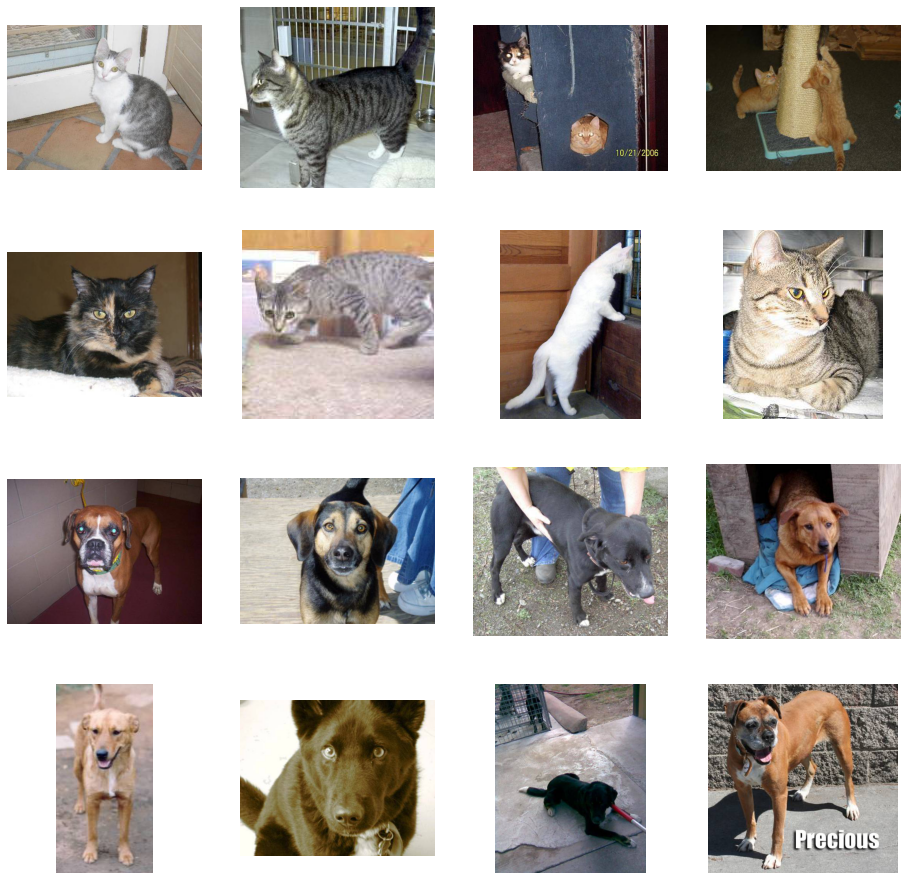

In [ ]:
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)

pic_index += 8
next_human_pic = [os.path.join(train_cats_dir, fname)
                for fname in train_cats_names[pic_index-8:pic_index]]

next_animal_pic = [os.path.join(train_dogs_dir, fname)
                for fname in train_dogs_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_human_pic+next_animal_pic):
  sp = plt.subplot(rows, cols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = tf.keras.models.Sequential()
model.add(Conv2D(64, (3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation = 'relu',))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("Training reached 95% accuracy rate so cancelling training")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory('/content/data/dog_vs_cat/dataset/training_set',
                                                    batch_size=128,
                                                    class_mode='binary',
                                                    classes = ['cats', 'dogs'],
                                                    target_size=(150, 150))

validation_generator = validation_datagen.flow_from_directory('/content/data/dog_vs_cat/dataset/test_set',
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

print(train_generator.class_indices)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


In [ ]:
history = model.fit(
            train_generator,
            # steps_per_epoch = 40,
            epochs=15,
            verbose=0,
            callbacks = [callbacks],
            validation_data = validation_generator
            )

Training reached 95% accuracy rate so cancelling training


In [ ]:
model.save('cats_vs_dog_classifier.h5')

In [ ]:
# import pickle

# pickle.dump(model, open('cats_vs_dogs_model.pkl','wb'))

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/cats_vs_dog_classifier.h5")

In [ ]:
# model_pkl = pickle.load(open('/content/cats_vs_dogs_model.pkl','rb'))

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

Saving 20210814_204544.jpg to 20210814_204544 (1).jpg
[0.3937126]
20210814_204544.jpg is a cat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import load_model as l_d

# tf.compat.v1.disable_eager_execution()

# CATEGORIES = ["Human", "Person"]



# IMG_SIZE = 128
# model = l_d("/content/github/Image_Classifier/CNN.model")
# img = ("/content/gfh.png") 
# grayscaled_image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
# img_resized = cv2.resize(grayscaled_image, (IMG_SIZE, IMG_SIZE))
# img_resized = img_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# img = img_resized

# # first element in prediction array = 'human'
# # second element in prediction array = 'person'

# def extract_Human():
    
#     prediction = model.predict([img])
#     prediction = list(prediction[0])
#     if(prediction[0] >= 0.9):
#         print(CATEGORIES[np.argmax(prediction)])
#         i = prediction[0]
#         print(str(i*100)+str('%'))
#     elif (prediction[1] >=0.9 ):
#         print(CATEGORIES[np.argmax(prediction)])
#         i = prediction[1]
#         print(str(i*100)+str('%'))
#     elif (prediction[1] <0.9 and prediction[0]>=0.9):
#         print("You're not a person")   
#     elif (prediction[0]<0.9 and prediction[1]>=0.9):
#         print("You're not a human")
#     else:
#         print("ERROR")

# extract_Human()